In [ ]:
import numpy as np
import pandas as pd 

In [2]:
building_df = pd.read_csv("./ashrae-energy-prediction/building_metadata.csv")
weather_train = pd.read_csv("./ashrae-energy-prediction/weather_train.csv")
train = pd.read_csv("./ashrae-energy-prediction/train.csv")

In [3]:
building_df['floor_count'] = building_df['floor_count'].isna()
building_df['floor_count'] = np.where((building_df.floor_count == True), 1, building_df.floor_count)
building_df['floor_count'] = np.where((building_df.floor_count == False), 0, building_df.floor_count)

weather_train = weather_train.groupby('site_id').apply(lambda x: x.interpolate(method='index'))
weather_train = weather_train.groupby('site_id').apply(lambda x: x.bfill())
weather_train = weather_train.groupby('site_id').apply(lambda x: x.ffill())

In [4]:
train = train.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")

del weather_train

In [5]:
import math

def Vnorth(num):
    val = math.cos(math.radians(num))
    return val
    
def Veast(num):
    val = math.sin(math.radians(num))
    return val

train['V_north'] = train['wind_direction'].apply(Vnorth)
train['V_north'] = train['V_north']*train['wind_speed']
train['V_east'] = train['wind_direction'].apply(Veast)
train['V_east'] = train['V_east']*train['wind_speed']

In [6]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
train['is_holiday'] = (train['timestamp'].dt.date.astype('datetime64').isin(us_holidays))
# test['is_holiday'] = (test['timestamp'].dt.date.astype('datetime64').isin(us_holidays))

In [8]:
train = train.drop("timestamp", axis = 1)
train = train[train['building_id'] != 1099]

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le = LabelEncoder()
train["primary_use"] = le.fit_transform(train["primary_use"])

In [11]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]
# drop_cols = ["building_id", "precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]

In [12]:
# categoricals = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]
# numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage", "dew_temperature"]
categoricals = ["building_id", "is_holiday", "floor_count", "primary_use", "hour", "day", "weekend", "month", "meter"]
numericals = ["V_north", "V_east", "square_feet", "year_built", "air_temperature", "cloud_coverage", "dew_temperature"]
target = np.log1p(train["meter_reading"])

feat_cols = categoricals + numericals

del train["meter_reading"]

In [13]:
train = train.drop(drop_cols, axis = 1)

In [14]:
train.isna().sum()

building_id               0
meter                     0
site_id                   0
primary_use               0
square_feet               0
year_built         12110079
floor_count               0
air_temperature       90493
cloud_coverage       567394
dew_temperature       90493
V_north               90493
V_east                90493
hour                      0
day                       0
weekend                   0
month                     0
is_holiday                0
dtype: int64

In [15]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [16]:
train, NAlist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 2484.9041805267334  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int32
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this col:  875000
dtype after:  uint32
******************************
******************************
Column:  year_built
dtype before:  float64
min for this col:  1900.0
m

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = True, random_state = 7)
error = 0
models = []
for i, (train_index, val_index) in enumerate(kf.split(train)):
    if i + 1 < num_folds:
        continue
    print(train_index.max(), val_index.min())
    train_X = train[feat_cols].iloc[train_index]
    val_X = train[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y > 0)
    lgb_eval = lgb.Dataset(val_X, val_y > 0)
    params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000, # num_iterations
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20) # 20
    
    lgb_train = lgb.Dataset(train_X[train_y > 0], train_y[train_y > 0])
    lgb_eval = lgb.Dataset(val_X[val_y > 0] , val_y[val_y > 0])
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.5,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
#     models.append(gbm)

    y_pred = (gbm_class.predict(val_X, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(val_X, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(y_pred, (val_y)))/num_folds
    print(np.sqrt(mean_squared_error(y_pred, (val_y))))
    break
print(error)

20198533 14
[LightGBM] [Info] Number of positive: 14659395, number of negative: 1499433
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.525959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 16158828, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.907207 -> initscore=2.279994
[LightGBM] [Info] Start training from score 2.279994
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.186405	valid_1's binary_logloss: 0.18642
[40]	training's binary_logloss: 0.158839	valid_1's binary_logloss: 0.158794
[60]	training's binary_logloss: 0.148672	valid_1's binary_logloss: 0.148646
[80]	training's binary_logloss: 0.139912	valid_1's binary_logloss: 0.139881
[100]	training's binary_logloss: 0.133481	valid_1's binary_logloss: 0.133457
[120]	training's binary_logloss: 0.127878	va

[1080]	training's rmse: 0.413982	valid_1's rmse: 0.418921
[1100]	training's rmse: 0.412546	valid_1's rmse: 0.417556
[1120]	training's rmse: 0.411404	valid_1's rmse: 0.416493
[1140]	training's rmse: 0.41043	valid_1's rmse: 0.415601
[1160]	training's rmse: 0.409098	valid_1's rmse: 0.414403
[1180]	training's rmse: 0.407725	valid_1's rmse: 0.413168
[1200]	training's rmse: 0.40664	valid_1's rmse: 0.412198
[1220]	training's rmse: 0.405762	valid_1's rmse: 0.411382
[1240]	training's rmse: 0.404497	valid_1's rmse: 0.410157
[1260]	training's rmse: 0.403441	valid_1's rmse: 0.40918
[1280]	training's rmse: 0.402355	valid_1's rmse: 0.408187
[1300]	training's rmse: 0.401154	valid_1's rmse: 0.407058
[1320]	training's rmse: 0.400053	valid_1's rmse: 0.40605
[1340]	training's rmse: 0.399076	valid_1's rmse: 0.405164
[1360]	training's rmse: 0.398033	valid_1's rmse: 0.404206
[1380]	training's rmse: 0.39706	valid_1's rmse: 0.403316
[1400]	training's rmse: 0.396026	valid_1's rmse: 0.402348
[1420]	training's r

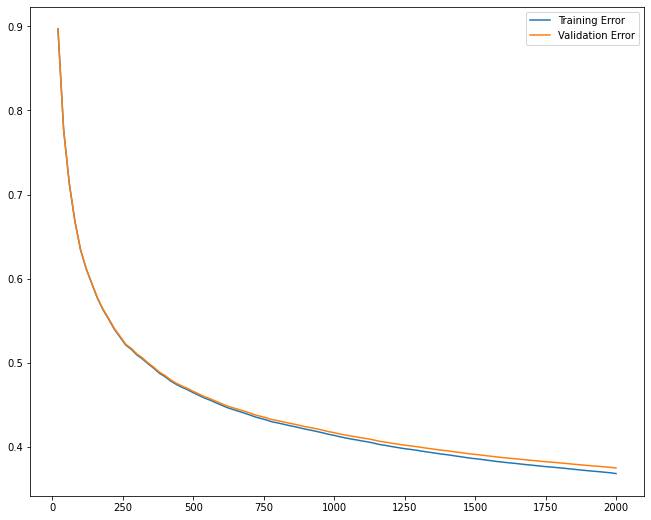

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize=(11,9))
x_values = [i for i in range(20,2001,20)]
y_values_1 = [0.897009,0.777346,0.713458,0.668537,0.63438,0.611755,0.594055,0.576776,0.562838,0.551686,0.539857,0.530573,0.52117,0.516004,0.509245,0.504465,0.498596,0.493409,0.487495,0.483388,0.478268,0.474172,0.470762,0.467849,0.464406,0.461219,0.457974,0.455496,0.452448,0.44961,0.446688,0.44451,0.442377,0.440256,0.437991,0.435535,0.433762,0.431893,0.429683,0.428414,0.426919,0.425319,0.423994,0.422442,0.420888,0.419593,0.418116,0.416581,0.414903,0.413644,0.411996,0.410634,0.409278,0.408215,0.406897,0.405866,0.404439,0.402848,0.401826,0.400571,0.399451,0.398328,0.397413,0.396543,0.395519,0.394441,0.393431,0.392451,0.391441,0.39066,0.389697,0.388668,0.387719,0.386661,0.385936,0.385143,0.384223,0.383365,0.382471,0.381738,0.381031,0.380382,0.379634,0.378901,0.378255,0.377531,0.376816,0.376236,0.375716,0.374977,0.374389,0.373673,0.372999,0.372287,0.371654,0.371036,0.370444,0.369796,0.369141, 0.368227]
y_values_2 = [0.896388,0.77701,0.713173,0.668348,0.634398,0.612173,0.594536,0.577257,0.563599,0.552613,0.540807,0.531643,0.522115,0.517057,0.510466,0.505709,0.499754,0.494578,0.488844,0.48481,0.479704,0.475637,0.472248,0.469397,0.465997,0.462853,0.45963,0.457169,0.454191,0.451432,0.448592,0.446554,0.444546,0.44249,0.440381,0.437951,0.436223,0.434446,0.432349,0.431115,0.429649,0.428128,0.426855,0.425312,0.423837,0.422608,0.421228,0.419739,0.418061,0.416876,0.415302,0.414045,0.41278,0.411786,0.410513,0.40955,0.408203,0.406684,0.405728,0.404495,0.403484,0.402448,0.401589,0.400778,0.399837,0.398814,0.397857,0.396957,0.396063,0.395311,0.394437,0.393494,0.392672,0.391671,0.391067,0.390279,0.389452,0.388689,0.387862,0.387169,0.386518,0.38591,0.385228,0.384569,0.383954,0.383314,0.38261,0.382064,0.381574,0.380897,0.380336,0.379672,0.379054,0.378438,0.377854,0.37729,0.376766,0.376178,0.375607,0.374773]
plt.plot(x_values, y_values_1, label='Training Error')
plt.plot(x_values, y_values_2, label='Validation Error')
plt.legend(loc='upper right')
plt.show()

In [19]:
sorted(zip(gbm_regress.feature_importance(), gbm_regress.feature_name()),reverse = True)

[(10028, 'building_id'),
 (9810, 'square_feet'),
 (5706, 'month'),
 (5233, 'hour'),
 (4890, 'meter'),
 (4521, 'air_temperature'),
 (3447, 'dew_temperature'),
 (3438, 'year_built'),
 (3385, 'primary_use'),
 (3164, 'day'),
 (2277, 'weekend'),
 (1286, 'cloud_coverage'),
 (1075, 'V_east'),
 (989, 'V_north'),
 (551, 'floor_count'),
 (200, 'is_holiday')]

In [20]:
import gc
del train

In [21]:
del train_X, val_X, lgb_train, lgb_eval, train_y, val_y, y_pred, target

In [22]:
gc.collect()

3292

In [23]:
#preparing test data
test = pd.read_csv("./ashrae-energy-prediction/test.csv")
# test, NAlist = reduce_mem_usage(test)
test = test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
del building_df
gc.collect()

0

In [24]:
test["primary_use"] = le.transform(test["primary_use"])

In [25]:
test, NAlist = reduce_mem_usage(test)

Memory usage of properties dataframe is : 2863.14697265625  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int32
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this

In [26]:
gc.collect()

60

In [27]:
weather_test = pd.read_csv("./ashrae-energy-prediction/weather_test.csv")

In [28]:
weather_test = weather_test.groupby('site_id').apply(lambda x: x.interpolate(method='index'))
weather_test = weather_test.groupby('site_id').apply(lambda x: x.bfill())
weather_test = weather_test.groupby('site_id').apply(lambda x: x.ffill())

In [29]:
test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
del weather_test

In [30]:
test['V_north'] = test['wind_direction'].apply(Vnorth)
test['V_north'] = test['V_north']*test['wind_speed']
test['V_east'] = test['wind_direction'].apply(Veast)
test['V_east'] = test['V_east']*test['wind_speed']

In [31]:
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = test["timestamp"].dt.hour.astype(np.uint8)
test["day"] = test["timestamp"].dt.day.astype(np.uint8)
test["weekend"] = test["timestamp"].dt.weekday.astype(np.uint8)
test["month"] = test["timestamp"].dt.month.astype(np.uint8)

In [32]:
test.columns

Index(['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'V_north',
       'V_east', 'hour', 'day', 'weekend', 'month'],
      dtype='object')

In [33]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
# train['is_holiday'] = (train['timestamp'].dt.date.astype('datetime64').isin(us_holidays))
test['is_holiday'] = (test['timestamp'].dt.date.astype('datetime64').isin(us_holidays))

test = test[feat_cols]

In [34]:
# test = test.drop(drop_cols, axis = 1)

In [35]:
from tqdm import tqdm
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
    
    res.append(np.expm1((gbm_class.predict(test.iloc[i:i+step_size], num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(test.iloc[i:i+step_size], num_iteration=gbm_regress.best_iteration))))
    i+=step_size

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 834/834 [14:48<00:00,  1.07s/it]


In [36]:
del test

In [37]:
res = np.concatenate(res)

In [38]:
sub = pd.read_csv("./ashrae-energy-prediction/sample_submission.csv")
sub["meter_reading"] = res
sub.to_csv("submission_origin_F.csv", index = False)

In [68]:
import numpy as np
import pandas as pd 

df1 = pd.read_csv("./ashrae-energy-prediction/1submission_122_F.csv")
df2 = pd.read_csv("./ashrae-energy-prediction/2submission_42_F.csv")
df3 = pd.read_csv("./ashrae-energy-prediction/3submission_origin_F.csv")
df4 = pd.read_csv("./ashrae-energy-prediction/4submission_7.csv")

In [69]:
df1['meter_reading2'] = df2['meter_reading']
df1['meter_reading3'] = df3['meter_reading']
df1['meter_reading4'] = df4['meter_reading']
df1['agg'] = ((df1['meter_reading']*3)+(df2['meter_reading']*2)+df3['meter_reading']+df4['meter_reading'])/7
df1.sample(20)

,row_id,meter_reading,meter_reading2,meter_reading3,meter_reading4,agg
30248983,30248983,269.796388,215.450646,218.120410,230.879907,241.327253
1208355,1208355,0.000000,0.000000,0.000000,0.000000,0.000000
25277898,25277898,0.000000,0.000000,0.000000,0.000000,0.000000
24521439,24521439,65.621115,78.126852,64.013849,69.106262,69.462451
8278838,8278838,83.497725,81.485141,104.650927,76.198276,84.901808
40000940,40000940,494.163825,446.315063,465.857884,417.279947,465.465633
35292606,35292606,0.000000,0.000000,0.000000,0.000000,0.000000
19785371,19785371,1198.333906,1843.599746,1434.603571,1143.448298,1408.607583
24677863,24677863,0.000000,0.000000,0.000000,0.000000,0.000000
15368724,15368724,2.158505,2.080908,2.697494,1.584464,2.131327


In [70]:
print((1236.183696*3+1037.522986*2+1721.146923+1955.971804)/7)

1351.530826714286


In [72]:
import numpy as np
import pandas as pd 

df1 = pd.read_csv("./submission_avg.csv")
df2 = pd.read_csv("./submission_avg2.csv")
df3 = pd.read_csv("./submission_avg3.csv")

In [73]:
df1['meter_reading']= ((df1['meter_reading']*4)+(df2['meter_reading']*2)+df3['meter_reading'])/7
df1.to_csv("submission_avg_avg1.csv", index = False) 

In [67]:
del df1
del df2
del df3
del df4